<br/>

# *Analysis of Domestic Airline Performance*

<br/>

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

# standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter


# I've got style,
# miles and miles
import seaborn as sns
sns.set()
sns.set_context(context='notebook', font_scale=1.5)
cp = sns.xkcd_rgb

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


[(0.69227222075649331, 0.092272204803485525, 0.16770473370949396),
 (0.83921569585800171, 0.37647059559822083, 0.30196079611778259),
 (0.95455594273174504, 0.64175319262579378, 0.5057285948126925),
 (0.99215686321258534, 0.85882353782653809, 0.78039216995239269),
 (0.96570549992954036, 0.96724336988785686, 0.96808919836493101),
 (0.81960785388946544, 0.89803922176361084, 0.94117647409439076),
 (0.56647445816619735, 0.76870435826918648, 0.8685121185639324),
 (0.26274511218070995, 0.57647061347961415, 0.76470589637756337),
 (0.12725875369620088, 0.3958477567808299, 0.66874281039424976)]

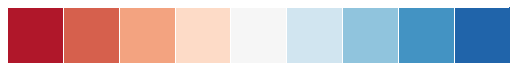

In [3]:
sns.choose_colorbrewer_palette('diverging')

In [4]:
sns.set_palette('Spectral', n_colors=6, desat=.8)

<br/>

## Data Acquisition and Preprocessing

- Load data from disparate files provided by the Department of Transportation


- Limit to "major" airlines


- Limit to "heavily trafficked" routes (serviced by 3+ carriers)


- Save data


<br/>

In [5]:
columns = ['Year',
           'Quarter',
           'Month',
           'DayofMonth',
           'DayOfWeek',
           'FlightDate',
           'UniqueCarrier',
           'Origin',
           'OriginCityName',
           'OriginState',
           'OriginStateName',
           'Dest',
           'DestCityName',
           'DestState',
           'DestStateName',
           'DepDelay',
           'DepDelayMinutes',
           'DepDel15',
           'ArrDelay',
           'ArrDelayMinutes',
           'ArrDel15',
           'Cancelled',
           'CancellationCode',
           'Flights',
           'Distance',
           'CarrierDelay',
           'WeatherDelay',
           'NASDelay',
           'SecurityDelay',
           'LateAircraftDelay']

airlines = pd.read_csv('./data/join-data/L_UNIQUE_CARRIERS.csv')
airlines.columns = ['UniqueCarrier', 'carrier_name']
airlines.UniqueCarrier = airlines.UniqueCarrier.apply(lambda x: str(x))
cancellations = pd.read_csv('./data/join-data/L_CANCELLATION.csv')

airlines_of_interest = ('AA', 'B6', 'DL', 'UA', 'VX', 'WN')

In [6]:
try:
    df = pd.read_csv('./data/definitive_flight_data.csv')
except:
    df = pd.read_csv('./data/On_Time_On_Time_Performance_2015_1.csv')
    df = df[columns]
    df = df[df.UniqueCarrier.apply(lambda x: x in airlines_of_interest)]

    for x in ['2015_2', '2015_3', '2015_4', '2015_5', '2015_6', '2015_7',
              '2015_8', '2015_9', '2015_10', '2015_11', '2015_12', '2016_1', '2016_2']:

        name_of_file = './data/On_Time_On_Time_Performance_' + x + '.csv' 
        tmpdf = pd.read_csv(name_of_file)
        tmpdf = tmpdf[tmpdf.UniqueCarrier.apply(lambda x: x in airlines_of_interest)]

        df = df.append(tmpdf[columns])
        
    df['year_month'] = df.apply(lambda x: str(x['Year']) + '-' + str(x['Month']), axis=1)
    df['num_flights'] = 1
    df = df.merge(airlines, on='UniqueCarrier')
    df['routes'] = df.Origin + df.Dest
    
    # Remove routes that are serviced by a single carrier
    routes = df.groupby(['Origin',
                         'Dest']).agg({"carrier_name": pd.Series.nunique}).reset_index().sort_values('carrier_name',
                                                                                                     ascending=False)
    routes = routes[routes.carrier_name >= 3]
    routes['good_routes'] = routes.Origin + routes.Dest
    good_routes = set(routes.good_routes)

    df = df[df.routes.apply(lambda x: x in good_routes)]
    
    df.to_csv('./data/definitive_flight_data.csv')

In [7]:
df.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,Origin,OriginCityName,...,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,year_month,num_flights,ArrDel30,carrier_name,routes
0,0,2015,1,1,1,4,2015-01-01,AA,JFK,"New York, NY",...,NaN,NaN,NaN,NaN,NaN,2015-1,1,0,American Airlines Inc.,JFKLAX
1,1,2015,1,1,2,5,2015-01-02,AA,JFK,"New York, NY",...,NaN,NaN,NaN,NaN,NaN,2015-1,1,0,American Airlines Inc.,JFKLAX
2,2,2015,1,1,3,6,2015-01-03,AA,JFK,"New York, NY",...,NaN,NaN,NaN,NaN,NaN,2015-1,1,0,American Airlines Inc.,JFKLAX
3,3,2015,1,1,4,7,2015-01-04,AA,JFK,"New York, NY",...,NaN,NaN,NaN,NaN,NaN,2015-1,1,0,American Airlines Inc.,JFKLAX
4,4,2015,1,1,5,1,2015-01-05,AA,JFK,"New York, NY",...,NaN,NaN,NaN,NaN,NaN,2015-1,1,0,American Airlines Inc.,JFKLAX


In [8]:
def group_and_make_rates(df, cols):
    dfg = df.groupby(cols).sum()[['Cancelled', 'ArrDel15', 'ArrDelay', 'num_flights']].reset_index()
    dfg['cancellation_rate'] = 1.0*dfg.Cancelled/dfg.num_flights
    dfg['delay_rate'] = 1.0*dfg.ArrDel15/dfg.num_flights
    
    return dfg

In [9]:
dfg = group_and_make_rates(df, ['UniqueCarrier', 'carrier_name', 'year_month'])
dfg['year_month'] = dfg.year_month.apply(lambda x: pd.tslib.Timestamp(x))

In [10]:
ao = group_and_make_rates(df, ['carrier_name'])
ao.sort_values('delay_rate', ascending=False)

,carrier_name,Cancelled,ArrDel15,ArrDelay,num_flights,cancellation_rate,delay_rate
2,JetBlue Airways,1463.0,20939.0,711828.0,84946,0.017223,0.246498
3,Southwest Airlines Co.,1718.0,22978.0,608392.0,105928,0.016219,0.216921
4,United Air Lines Inc.,1538.0,26342.0,552973.0,133270,0.011540,0.197659
5,Virgin America,401.0,8940.0,237669.0,46553,0.008614,0.192039
0,American Airlines Inc.,1901.0,23816.0,281844.0,134200,0.014165,0.177466
1,Delta Air Lines Inc.,1009.0,25776.0,285229.0,150581,0.006701,0.171177


In [11]:
aoo = ao.sort_values('delay_rate', ascending=False)['carrier_name'].values

<br/>

# *I. Visualizations* (OVERALL)

<br/>

<br/>

## Delay Rates by Carrier (Overall)

<br/>

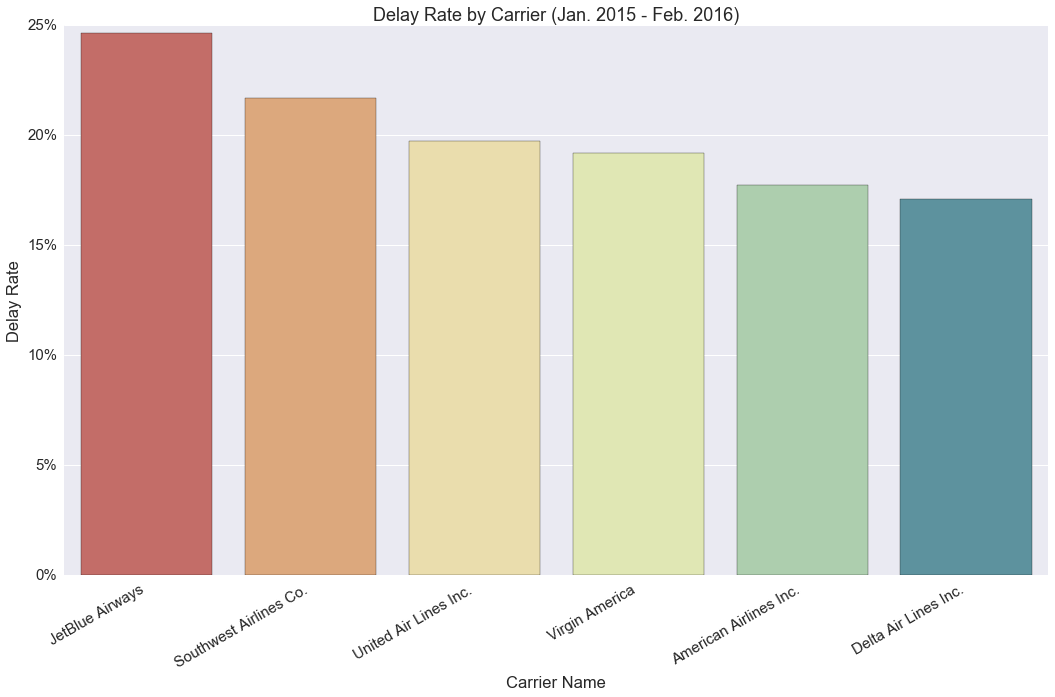

In [12]:
g = sns.factorplot('carrier_name', 'delay_rate',
                    data=ao, order=aoo, hue_order=aoo, kind='bar', legend=False, legend_out=False,
                    size=10, aspect=1.5)

g.fig.autofmt_xdate()
g.ax.set_xlabel('Carrier Name')
g.ax.set_ylabel('Delay Rate')
g.ax.set_title('Delay Rate by Carrier (Jan. 2015 - Feb. 2016)')
g.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

<br/>

## Monthly Delay Rates by Carrier (Overall)

<br/>

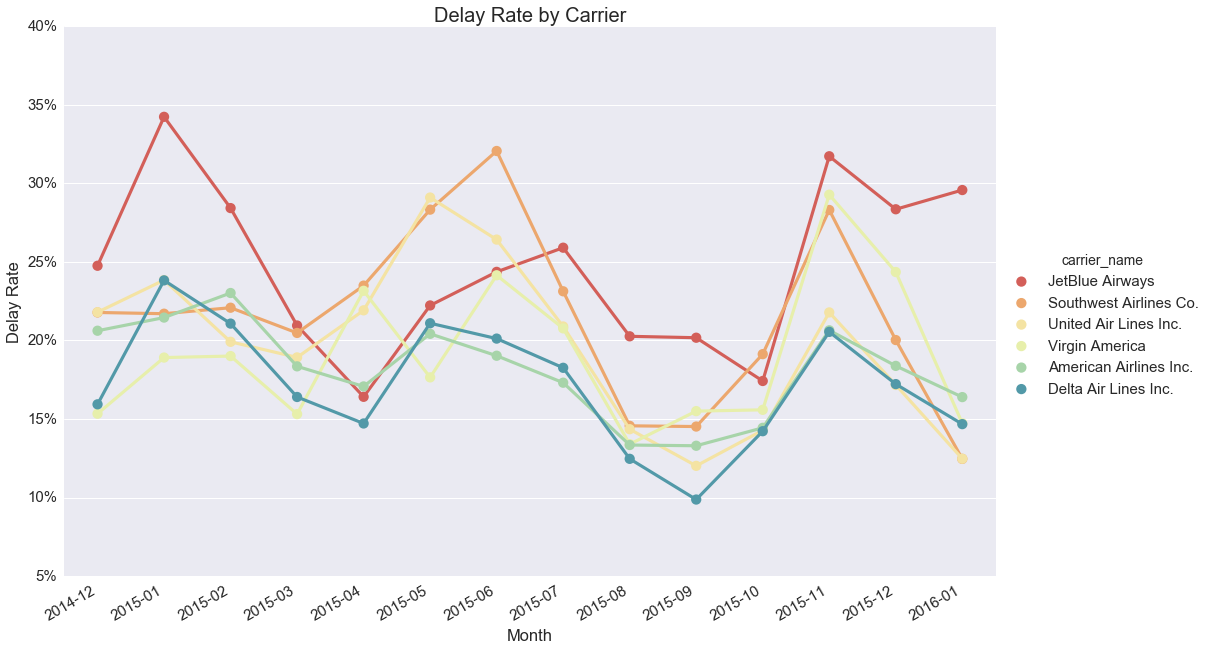

In [13]:
g = sns.factorplot('year_month', 'delay_rate', hue='carrier_name',
                   data=dfg, kind='point', hue_order=aoo, size=10, aspect=1.5)

g.ax.set_xlabel('Month')
g.ax.set_ylabel('Delay Rate')
g.ax.set_xticklabels([pd.datetime.strftime(pd.tslib.Timestamp(x.get_text()), '%Y-%m') for x in g.ax.get_xticklabels()])
g.ax.set_title('Delay Rate by Carrier', fontsize=20)

g.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

g.fig.autofmt_xdate()

<br/>

## Monthly Cancellation Rates by Carrier (Overall)

<br/>

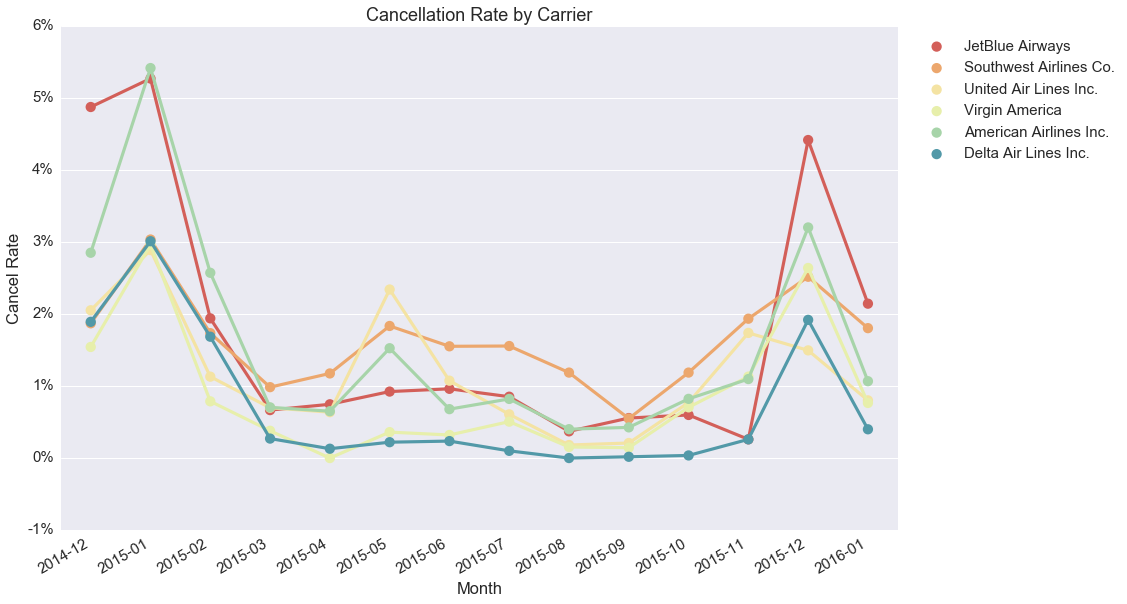

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

g = sns.factorplot('year_month', 'cancellation_rate', hue='carrier_name',
                   data=dfg, kind='point', ax=ax, hue_order=aoo)

ax.set_xlabel('Month')
ax.set_ylabel('Cancel Rate')
ax.set_xticklabels([pd.datetime.strftime(pd.tslib.Timestamp(x.get_text()), '%Y-%m') for x in ax.get_xticklabels()])
ax.set_title('Cancellation Rate by Carrier')

fig.autofmt_xdate()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax.legend(bbox_to_anchor=(1.275, 1.0))

plt.close(g.fig)

<br/>

## Delay Distribution by Carrier (Overall)

<br/>

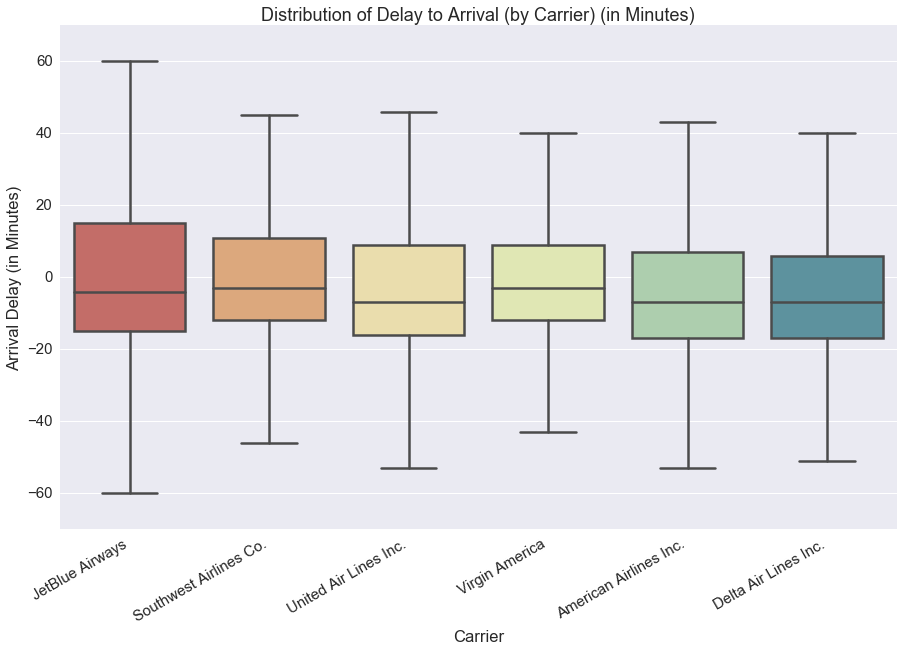

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

sns.boxplot('carrier_name', 'ArrDelay', data=df, linewidth=2.5, fliersize=0, hue_order=aoo, order=aoo)

ax.set_xlabel('Carrier')
ax.set_ylabel('Arrival Delay (in Minutes)')
ax.set_title('Distribution of Delay to Arrival (by Carrier) (in Minutes)')

ax.set_ylim(-70, 70)

fig.autofmt_xdate()

# ax.legend_.remove()

<br/>

# *II. Visualizations* (SFO --> LAX)

<br/>

In [16]:
dfg = group_and_make_rates(df[(df.Origin == 'SFO') & (df.Dest == 'LAX')], ['UniqueCarrier', 'carrier_name', 'year_month'])
dfg['year_month'] = dfg.year_month.apply(lambda x: pd.tslib.Timestamp(x))

In [17]:
ao = group_and_make_rates(df[(df.Origin == 'SFO') & (df.Dest == 'LAX')], ['carrier_name'])
ao.sort_values('delay_rate', ascending=False)

,carrier_name,Cancelled,ArrDel15,ArrDelay,num_flights,cancellation_rate,delay_rate
1,Delta Air Lines Inc.,20.0,910.0,54118.0,2248,0.008897,0.404804
2,Southwest Airlines Co.,293.0,887.0,34735.0,3872,0.075671,0.229081
3,United Air Lines Inc.,36.0,1020.0,33404.0,4454,0.008083,0.229008
4,Virgin America,23.0,901.0,34248.0,3935,0.005845,0.228971
0,American Airlines Inc.,21.0,566.0,17122.0,2475,0.008485,0.228687


In [18]:
aoo2 = ao.sort_values('delay_rate', ascending=False)['carrier_name'].values

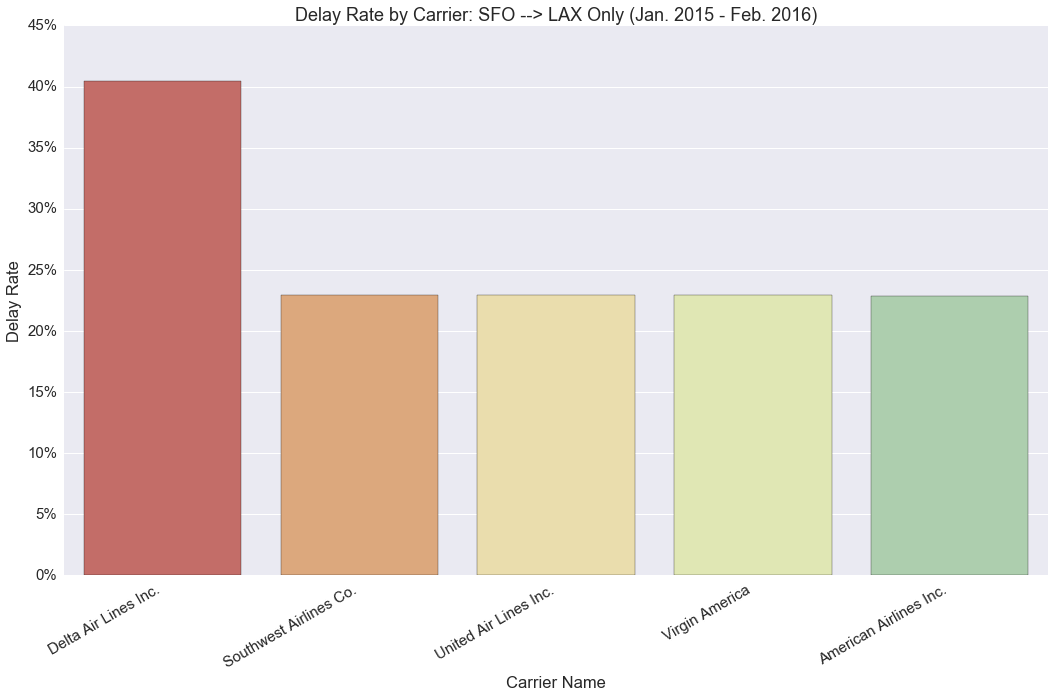

In [19]:
g = sns.factorplot('carrier_name', 'delay_rate',
                    data=ao, order=aoo2, hue_order=aoo2, kind='bar', legend=False, legend_out=False,
                    size=10, aspect=1.5)

g.fig.autofmt_xdate()
g.ax.set_xlabel('Carrier Name')
g.ax.set_ylabel('Delay Rate')
g.ax.set_title('Delay Rate by Carrier: SFO --> LAX Only (Jan. 2015 - Feb. 2016)')
g.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

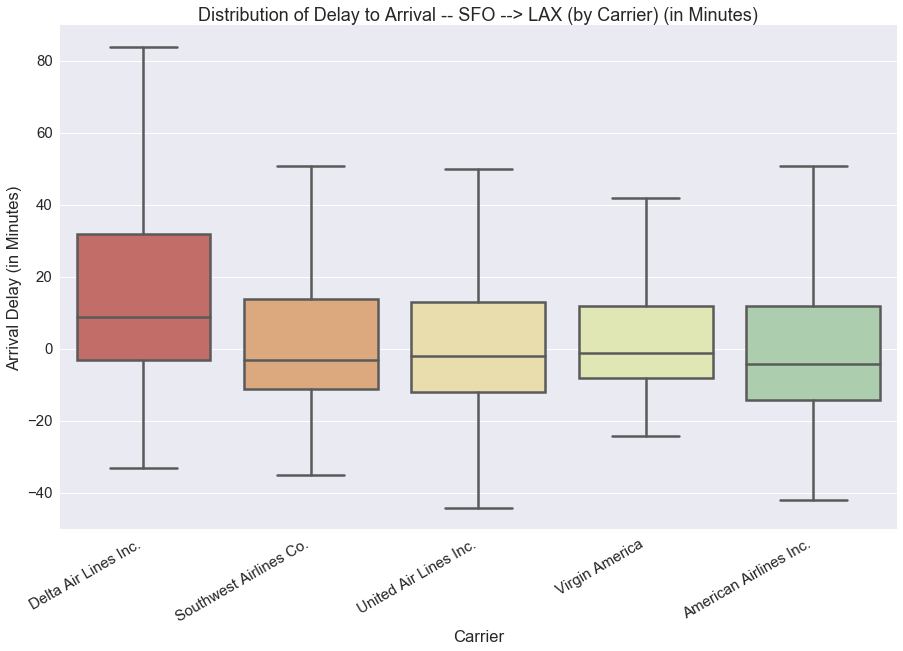

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

sns.boxplot('carrier_name', 'ArrDelay', data=df[(df.Origin == 'SFO') & (df.Dest == 'LAX')],
            linewidth=2.5, fliersize=0, hue_order=ao, order=aoo2)

ax.set_xlabel('Carrier')
ax.set_ylabel('Arrival Delay (in Minutes)')
ax.set_title('Distribution of Delay to Arrival -- SFO --> LAX (by Carrier) (in Minutes)')

ax.set_ylim(-50, 90)

fig.autofmt_xdate()

# ax.legend_.remove()

<br/>

# *III. Airline Delay/Cancellation Regression Analysis*

<br/>

(Note: doing this via rpy2 because I thought about fitting a multilevel model for a while)

<br/>

In [21]:
%%R

library(ggplot2)
library(lme4)
library(dplyr)
library(magrittr)
library(effects)

In [22]:
%Rpush df

In [23]:
%%R

df$DayOfWeek = as.factor(df$DayOfWeek)
fin = df %>% filter(!is.na(ArrDel15))

<br/>

## Delay

<br/>


 carrier_name effect
carrier_name
American Airlines Inc.   Delta Air Lines Inc.        JetBlue Airways 
             0.1787036              0.1806014              0.2417064 
Southwest Airlines Co.  United Air Lines Inc.         Virgin America 
             0.2231095              0.1894003              0.1744344 


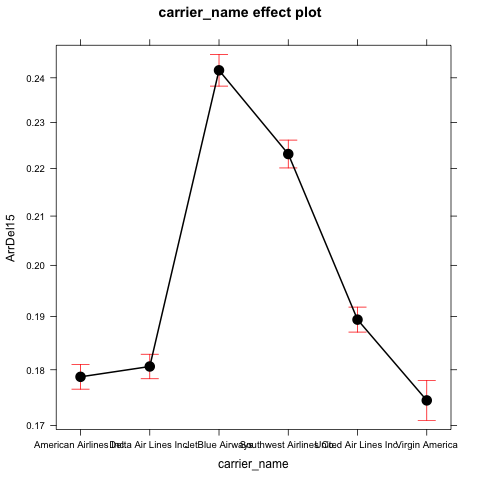

In [24]:
%%R

fit = glm(ArrDel15 ~ Distance + DayOfWeek + carrier_name + Dest + Origin, fin, family="binomial")
delay_effect = effect("carrier_name", fit)
print(delay_effect)
plot(delay_effect)

In [25]:
ao2 = pd.DataFrame({'carrier_name': ['American Airlines Inc.', 'Delta Air Lines Inc.', 'JetBlue Airways',
                                     'Southwest Airlines Co.', 'United Air Lines Inc.', 'Virgin America'],
                    'delay_rate': [0.1787036, 0.1806014, 0.2417064, 0.2231095, 0.1894003, 0.1744344]})

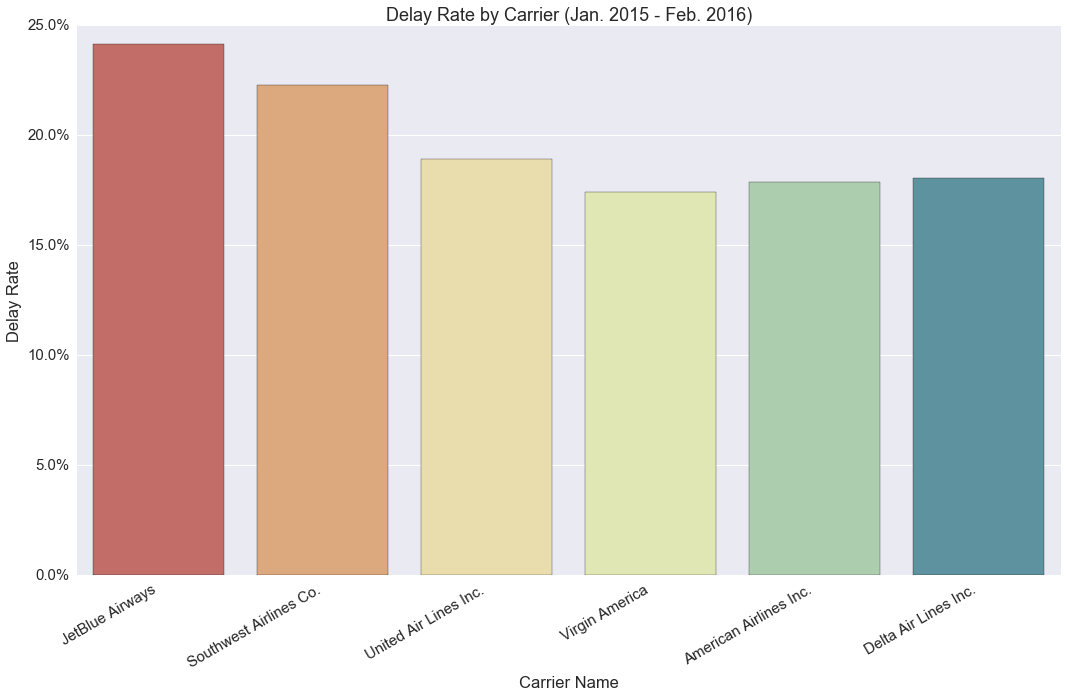

In [26]:
g = sns.factorplot('carrier_name', 'delay_rate',
                    data=ao2, order=aoo, hue_order=aoo, kind='bar', legend=False, legend_out=False,
                    size=10, aspect=1.5)

g.fig.autofmt_xdate()
g.ax.set_xlabel('Carrier Name')
g.ax.set_ylabel('Delay Rate')
g.ax.set_title('Delay Rate by Carrier (Jan. 2015 - Feb. 2016)')
g.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 

<br/>

## Cancellation

<br/>


 carrier_name effect
carrier_name
American Airlines Inc.   Delta Air Lines Inc.        JetBlue Airways 
           0.010358852            0.005319474            0.007433693 
Southwest Airlines Co.  United Air Lines Inc.         Virgin America 
           0.020910439            0.009740596            0.006172169 


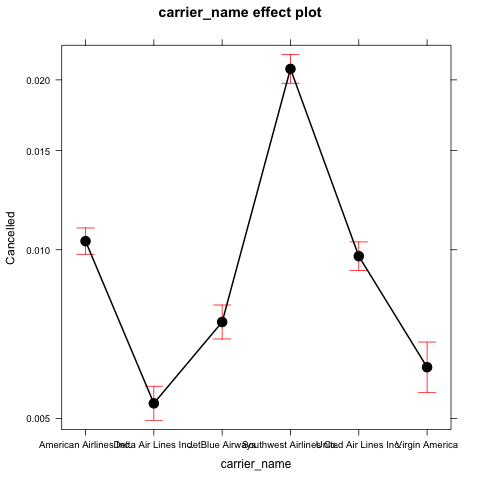

In [27]:
%%R

fin = df %>% filter(!is.na(Cancelled))

fit = glm(Cancelled ~ Distance + DayOfWeek + carrier_name + Dest + Origin, fin, family="binomial")
cancel_effect = effect("carrier_name", fit)
print(cancel_effect)
plot(cancel_effect)

In [28]:
ao3 = pd.DataFrame({'carrier_name': ['American Airlines Inc.', 'Delta Air Lines Inc.', 'JetBlue Airways',
                                     'Southwest Airlines Co.', 'United Air Lines Inc.', 'Virgin America'],
                    'delay_rate': [0.010358852, 0.005319474, 0.007433693, 0.020910439, 0.009740596, 0.006172169]})

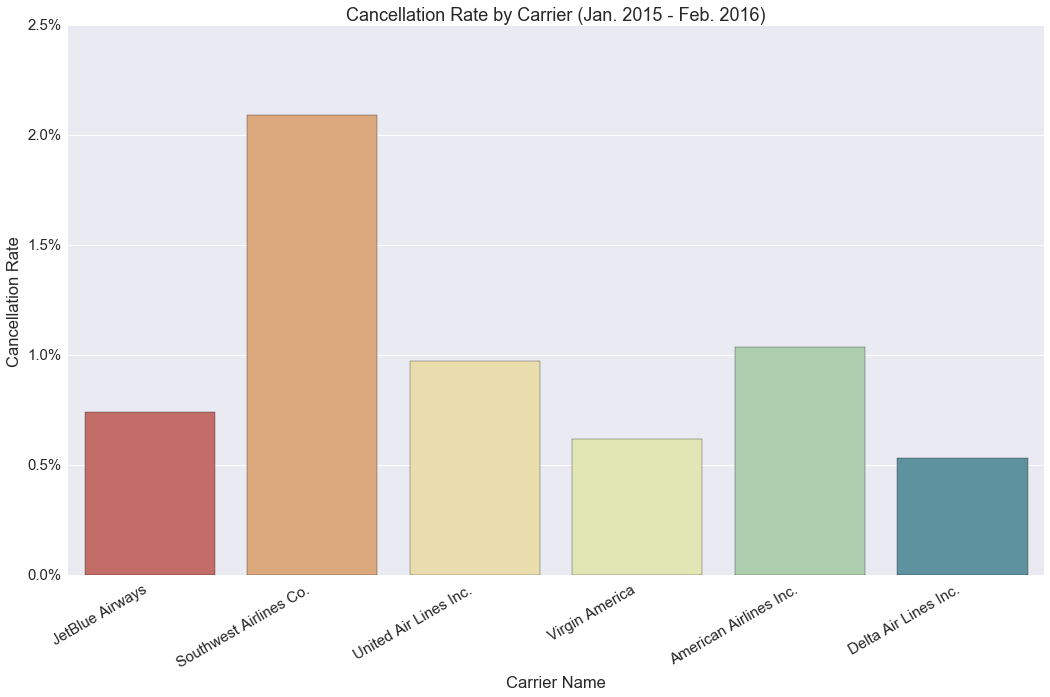

In [29]:
g = sns.factorplot('carrier_name', 'delay_rate',
                    data=ao3, order=aoo, hue_order=aoo, kind='bar', legend=False, legend_out=False,
                    size=10, aspect=1.5)

g.fig.autofmt_xdate()
g.ax.set_xlabel('Carrier Name')
g.ax.set_ylabel('Cancellation Rate')
g.ax.set_title('Cancellation Rate by Carrier (Jan. 2015 - Feb. 2016)')
g.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 